In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
import pandas as pd
import json

import glob

from scipy.spatial.transform import Rotation as R

from AngleHelpers import calculate_norm_dir_from_unity_angles

In [2]:
TIMESTAMP_DECIMALS = 2
TIME_DELTA = 0.01
RESAMPLE_STRATEGY = "MEAN" # "FILL" 
### MEAN: Resample using pandas' resample, fill holes with linear interpolation
### FILL: Round timestamps to closest 0.01s bucket, drop duplicate timestamps, fill holes with forward fillx


# PATHS
reference_data_path_some_failed_some_succeeded = "./post_recorded_reference_data/Build/Some_Failed_Some_Succeeded"
reference_data_path_all_failed = "./post_recorded_reference_data/Build/All_Failed"

save_path = "./post_recorded_reference_data/"

In [3]:
def read_normalized_json_to_df(filepath):
    full_file_df = ""
    with open(filepath, 'r', encoding="utf-8") as json_file:
        json_full = json.load(json_file)
    full_file_df = pd.json_normalize(json_full)
    return full_file_df
def save_to_disk(data, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)
def load_from_disk(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
        return data
    
    
def interpolate_outliers(data, m=2):
    
    # create index of data
    #index = list(data.index)
    # check where to remove outliers with 2 sigma distance
    outlier_bool = abs(data - np.mean(data)) > m * np.std(data)
    # get outlier indices 
    outlier_index = data[outlier_bool].index
    # check whether it is a one sample outlier 
    for i in outlier_index:
        # check boundary conditions
        if i == 0:
            data[i] = data[i+1]
            
        elif i == len(data) - 1:
            data[i] = data[i-1]
        
        else:
            data[i] = (data[i+1] + data[i-1])/2
            
        
    # apply to index and data and return
    return data


def correct_angle_outliers(data, m=2):
    
    # create index of data
    #index = list(data.index)
    # check where to remove outliers with 2 sigma distance
    data_convert = data.copy()
    data_convert = data_convert-180
    for i in range(len(data)):
        if data_convert[i] > 0:
            data_convert[i] = data_convert[i] - 180
        else:
            data_convert[i] = data_convert[i] + 180
            
    outlier_bool = abs(data_convert - np.mean(data_convert)) > m * np.std(data_convert)
    # get outlier indices 
    outlier_index = data[outlier_bool].index
    # check whether it is a one sample outlier 
    
    for i in outlier_index:
        # check boundary conditions
        if i == 0:
            data[i] = data[i+1]
            
        else:
            data[i] = data[i-1]
            
        
    # apply to index and data and return
    return data

### Data extraction
The reference files are loaded and saved in seperate dataframes in seperate dictionaries. 
The scenedata files are used to extract the event start and stop timestamps. 
The input files contain the car position and rotation data.
Those input files are used to extract path segments that are not events. 
Using the timestamps from the scenedata files, the segments are labeled from 0 to 3;
the datapoints that belong to events are -9. 
The segments are extracted and stored seperately within the input files dictionary. 
The segments timestamps are rebased based on the last event's stop timestamp (or for first segment to 0).

Resampling: 
Since the existing data (without car world coordinates) and the new data need to be synched somehow,
datapoints' timestamps are rounded to 0.01s seconds. 
Additionally, missing holes are filled with linearly interpolated values. 
The 0.01s time delta is also useful as proper timeseries data for the model. 

Convenience Dictionary:
For convenient access of the reference paths.

In [4]:
def _read_raw_car_reference_files(reference_data_path):

    print("\nTotal number of reference files: " + str(len(os.listdir(reference_data_path)))) 
    print("Path: " + reference_data_path)
    
    # Check if reference files were processed before 
    if (os.path.isfile(os.path.join(reference_data_path, "combined_reference_data.pickle"))):
        print("Loading previously processed reference files...")
        combined_ref_data = load_from_disk(os.path.join(reference_data_path, "combined_reference_data.pickle"))
        reference_input_files = combined_ref_data["reference_input_files"] 
        reference_eyetracking_files = combined_ref_data["reference_eyetracking_files"] 
        reference_scenedata_files = combined_ref_data["reference_scenedata_files"]
        reference_data_files_path = combined_ref_data["reference_data_files_path"]
        reference_participant_calibration_file = combined_ref_data["reference_participant_calibration_file"]
        print("Files were initially processed from path: " + reference_data_files_path)
        print("Finished loading reference files.")
    
    # Read raw post recorded reference data 
    else:
        print("Loading raw reference files...")
        reference_input_files = {}
        reference_eyetracking_files = {}
        reference_scenedata_files = {}
        reference_participant_calibration_file = {}
        reference_participant_calibration_file['filename'] = glob.glob(reference_data_path + "/*ParticipantCalibrationData.txt")[0]
        reference_participant_calibration_file['full_df'] = read_normalized_json_to_df(glob.glob(reference_data_path + "/*ParticipantCalibrationData.txt")[0])
        for filename in glob.glob(reference_data_path + "/*_Input*.txt"):
            if "Westbrueck" in filename:
                token = "Westbrueck"
            elif "MountainRoad" in filename:
                token = "MountainRoad"
            elif "CountryRoad" in filename:
                token = "CountryRoad"
            elif "Autobahn" in filename:
                token = "Autobahn"
            else:  # not defined 
                continue # in the loop 
            reference_input_files[token] = {}
            reference_input_files[token]["filename"] = filename
            reference_input_files[token]["full_df"] = read_normalized_json_to_df(filename)
        for filename in glob.glob(reference_data_path + "/*_EyeTracking*.txt"):
            if "Westbrueck" in filename:
                token = "Westbrueck"
            elif "MountainRoad" in filename:
                token = "MountainRoad"
            elif "CountryRoad" in filename:
                token = "CountryRoad"
            elif "Autobahn" in filename:
                token = "Autobahn"  
            else:  # not defined 
                continue # in the loop     
            reference_eyetracking_files[token] = {}
            reference_eyetracking_files[token]["filename"] = filename
            reference_eyetracking_files[token]["full_df"] = read_normalized_json_to_df(filename)
        for filename in glob.glob(reference_data_path + "/*_SceneData*.txt"): 
            if "Westbrueck" in filename:
                token = "Westbrueck"
            elif "MountainRoad" in filename:
                token = "MountainRoad"
            elif "CountryRoad" in filename:
                token = "CountryRoad"
            elif "Autobahn" in filename:
                token = "Autobahn"     
            else:  # not defined 
                continue # in the loop  
            reference_scenedata_files[token] = {}
            reference_scenedata_files[token]["filename"] = filename
            reference_scenedata_files[token]["full_df"] = read_normalized_json_to_df(filename)

        # Save processed reference files 
        print("Finished loading reference files.")
        print("Saving combined reference data to disk...")
        combined_ref_data = {}
        combined_ref_data["reference_data_files_path"] = reference_data_path
        combined_ref_data["reference_input_files"] = reference_input_files
        combined_ref_data["reference_eyetracking_files"] = reference_eyetracking_files
        combined_ref_data["reference_scenedata_files"] = reference_scenedata_files
        combined_ref_data["reference_participant_calibration_file"] = reference_participant_calibration_file
        save_to_disk(combined_ref_data, os.path.join(reference_data_path, "combined_reference_data.pickle"))
        print("Finished saving combined reference data to disk.")
    
    return reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file

In [5]:
def _extract_event_information(reference_data_path):
    
    # load raw files 
    reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file = _read_raw_car_reference_files(reference_data_path)
    
    
    # Extract most important event information 
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        reference_scenedata_files[area]["number_of_events"] = len(reference_scenedata_files[area]["full_df"]["EventBehavior"][0])
        reference_scenedata_files[area]["events"] = {}
        for idx, event in enumerate(reference_scenedata_files[area]["full_df"]["EventBehavior"][0]):
            reference_scenedata_files[area]["events"][idx] = {'name':event["EventName"],'start':event["StartofEventTimeStamp"],'stop':event["EndOfEventTimeStamp"],'succeeded':event["SuccessfulCompletionState"]}
                
    return reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file

In [6]:
def _extract_path_segments(reference_data_path):
    
    # extract event information
    reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file = _extract_event_information(reference_data_path)
    
    
    # Copy of entire dataframe input dataframe to prepare processing
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        reference_input_files[area]["processed_df"] = reference_input_files[area]["full_df"].copy(deep=True)
        reference_input_files[area]["processed_df"].drop(columns=["ReceivedInput","SteeringInput","AcellerationInput","BrakeInput"],inplace=True)
        reference_input_files[area]["processed_df"]["path_segment_label"] = -9 # event label 

    # Give label to individual path segments, -9 is event label 
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        for event_idx in range(len(reference_scenedata_files[area]["events"]) + 1):
            cond = None 
            if event_idx == 0: # find all datapoints with timestamps before event start timestamp 
                cond = (reference_input_files[area]["processed_df"]["TimeStamp"] < reference_scenedata_files[area]["events"][event_idx]["start"])
            elif event_idx < len(reference_scenedata_files[area]["events"]): # find all datapoints with timestamp between prev and next event 
                cond = (reference_input_files[area]["processed_df"]["TimeStamp"] > reference_scenedata_files[area]["events"][event_idx - 1]["stop"]) & (reference_input_files[area]["processed_df"]["TimeStamp"] < reference_scenedata_files[area]["events"][event_idx]["start"])
            elif event_idx == len(reference_scenedata_files[area]["events"]): # find all datapoints with timestamp after last event
                cond = (reference_input_files[area]["processed_df"]["TimeStamp"] > reference_scenedata_files[area]["events"][event_idx - 1]["stop"])

            # Filter     
            reference_input_files[area]["processed_df"].loc[cond, "path_segment_label"] = event_idx

    # Extract path segments, add timestamps beginning at zero 
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        reference_input_files[area]["path_segments_no_resample"] = {}
        for label in reference_input_files[area]["processed_df"]["path_segment_label"].unique():
            if (label != -9):

                # copy segment data 
                cond = (reference_input_files[area]["processed_df"]["path_segment_label"] == label)
                reference_input_files[area]["path_segments_no_resample"][label] = reference_input_files[area]["processed_df"].loc[cond].copy(deep=True)

                # add timestamp starting at zero 
                if label == 0: # take first recorded datapoint as base timestamp 
                    ref_timestamp = reference_input_files[area]["path_segments_no_resample"][label]["TimeStamp"].iloc[0]
                else: # take last event's stop time as base timestamp 
                    ref_timestamp = reference_scenedata_files[area]["events"][label - 1]["stop"]

                reference_input_files[area]["path_segments_no_resample"][label]["rebased_timestamp"] = reference_input_files[area]["path_segments_no_resample"][label]["TimeStamp"] - ref_timestamp

            else: # skip events 
                pass 
    
    return reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file

In [7]:
# Resample path segments 

def _resample_reference_path_segments(reference_data_path):

    # extract path segments
    reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file = _extract_path_segments(reference_data_path)
    
    print("Resampled path segments (excl. events):")
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:

        reference_input_files[area]["path_segments_resampled"] = {}
        for segment in reference_input_files[area]["path_segments_no_resample"]:
            # copy segments 
            reference_input_files[area]["path_segments_resampled"][segment] = reference_input_files[area]["path_segments_no_resample"][segment].copy(deep=True)

            # Hard match datapoints to closest timebin and fill arising holes by forward fill 
            if RESAMPLE_STRATEGY == "FILL":

                # round the timestamps to specified number of decimals 
                reference_input_files[area]["path_segments_resampled"][segment]["rebased_timestamp_rounded"] = reference_input_files[area]["path_segments_resampled"][segment]["rebased_timestamp"].round(TIMESTAMP_DECIMALS)

                # "resample" timestamps by reindexing with time delta (default 0.01s) steps and filling holes; first drop duplicate timestamps
                reference_input_files[area]["path_segments_resampled"][segment]["resampled_timestamp"] = reference_input_files[area]["path_segments_resampled"][segment]["rebased_timestamp_rounded"] 
                reference_input_files[area]["path_segments_resampled"][segment].drop_duplicates(subset="resampled_timestamp",keep="first", inplace=True)
                start_time = 0
                end_time = reference_input_files[area]["path_segments_resampled"][segment]["resampled_timestamp"].iloc[-1]
                time_delta = TIME_DELTA
                new_index = pd.Index(np.arange(start_time,end_time,time_delta), name="resampled_timestamp")
                reference_input_files[area]["path_segments_resampled"][segment] = reference_input_files[area]["path_segments_resampled"][segment].set_index("resampled_timestamp").reindex(new_index).reset_index()

                # keep track of where data was interpolated 
                reference_input_files[area]["path_segments_resampled"][segment]["is_interpolated"] = reference_input_files[area]["path_segments_resampled"][segment]["rebased_timestamp"].isnull()

                # fill nans ("interpolate") 
                exclude_columns = ["rebased_timestamp","rebased_timestamp_rounded","is_interpolated","TimeStamp","resampled_timestamp"]
                for column in reference_input_files[area]["path_segments_resampled"][segment].columns:  
                    if column not in exclude_columns:
                        reference_input_files[area]["path_segments_resampled"][segment][column].fillna(method='ffill', inplace = True)
                        reference_input_files[area]["path_segments_resampled"][segment][column].fillna(method='bfill', inplace = True)

                # drop unneeded columns
                reference_input_files[area]["path_segments_resampled"][segment].drop(columns=["TimeStamp","rebased_timestamp","rebased_timestamp_rounded","path_segment_label"], inplace = True)


            # Resample using pandas' resample, fill with mean 
            if RESAMPLE_STRATEGY == "MEAN":

                # copy timestamp 
                reference_input_files[area]["path_segments_resampled"][segment]["resampled_timestamp"] = reference_input_files[area]["path_segments_resampled"][segment]["rebased_timestamp"] 

                # create datetime from rebased timestamp
                reference_input_files[area]["path_segments_resampled"][segment]["rebased_datetime"] = pd.to_datetime(reference_input_files[area]["path_segments_resampled"][segment]['resampled_timestamp'],unit='s')

                # resample with time delta (default 0.01s) interval and keep track of holes in the data before interpolation
                reference_input_files[area]["path_segments_resampled"][segment] = reference_input_files[area]["path_segments_resampled"][segment].resample(str(TIME_DELTA) + 'S',on="rebased_datetime").mean()
                reference_input_files[area]["path_segments_resampled"][segment]["is_interpolated"] = reference_input_files[area]["path_segments_resampled"][segment]["resampled_timestamp"].isnull()
                reference_input_files[area]["path_segments_resampled"][segment].reset_index(inplace=True)

                # interpolate linearly
                reference_input_files[area]["path_segments_resampled"][segment].interpolate(method="linear",inplace=True)

                # get resampled_timestamp from rebased_datetime again 
                reference_input_files[area]["path_segments_resampled"][segment]["resampled_timestamp"] = (reference_input_files[area]["path_segments_resampled"][segment]["rebased_datetime"] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s')

                # drop unneeded columns
                reference_input_files[area]["path_segments_resampled"][segment].drop(columns=["rebased_datetime","TimeStamp","rebased_timestamp","path_segment_label"], inplace = True)


            print("Area: " + area + " Segment: " + str(segment) + " Total datapoints (incl. resampled): " + str(len(reference_input_files[area]["path_segments_resampled"][segment]["is_interpolated"]))  + " Filled NaNs: " + str(reference_input_files[area]["path_segments_resampled"][segment]["is_interpolated"].values.sum()))

            
    
    return reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file

In [8]:
def generate_reference_paths(reference_data_path):
    
    # get resampled path segments
    reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file = _resample_reference_path_segments(reference_data_path)
    
    # extract most important infos
    reference_paths = {}
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        reference_paths[area] = {}
        for segment in reference_input_files[area]["path_segments_resampled"]:
            reference_paths[area][segment] = reference_input_files[area]["path_segments_resampled"][segment].copy(deep = True)
            #reference_paths[area][segment].drop(columns=["path_segment_label","rebased_timestamp","rebased_timestamp_rounded"],inplace=True)
            
    
    # extract event infos 
    event_info = {}
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        event_info[area] = {}
        for event in reference_scenedata_files[area]["events"]:
            event_info[area][event] = {}
            event_info[area][event]['name'] = reference_scenedata_files[area]["events"][event]['name']
            event_info[area][event]['start'] = reference_scenedata_files[area]["events"][event]['start']
            event_info[area][event]['stop'] = reference_scenedata_files[area]["events"][event]['stop']
            event_info[area][event]['succeeded'] = reference_scenedata_files[area]["events"][event]['succeeded']
                        
    return reference_paths, event_info


In [9]:
# Generate the reference path cleaned data 
reference_paths_some_events_failed, event_info_some_events_failed = generate_reference_paths(reference_data_path_some_failed_some_succeeded)
reference_paths_all_events_failed, event_info_all_events_failed = generate_reference_paths(reference_data_path_all_failed)



Total number of reference files: 14
Path: ./post_recorded_reference_data/Build/Some_Failed_Some_Succeeded
Loading previously processed reference files...
Files were initially processed from path: ./post_recorded_reference_data/Build/Some_Failed_Some_Succeeded
Finished loading reference files.
Resampled path segments (excl. events):
Area: Westbrueck Segment: 0 Total datapoints (incl. resampled): 2459 Filled NaNs: 911
Area: Westbrueck Segment: 1 Total datapoints (incl. resampled): 2508 Filled NaNs: 917
Area: Westbrueck Segment: 2 Total datapoints (incl. resampled): 2372 Filled NaNs: 733
Area: Westbrueck Segment: 3 Total datapoints (incl. resampled): 2130 Filled NaNs: 624
Area: MountainRoad Segment: 0 Total datapoints (incl. resampled): 1995 Filled NaNs: 1029
Area: MountainRoad Segment: 1 Total datapoints (incl. resampled): 3685 Filled NaNs: 1708
Area: MountainRoad Segment: 2 Total datapoints (incl. resampled): 5253 Filled NaNs: 1865
Area: MountainRoad Segment: 3 Total datapoints (incl. 

In [10]:
reference_paths_some_events_failed['Westbrueck']

{0:       CarPosition.x  CarPosition.y  CarPosition.z  LocalCarPosition.x  \
 0        537.003540     220.836792    1457.486084        -1003.740234   
 1        536.645752     220.824692    1457.275391        -1003.509155   
 2        536.467194     220.818642    1457.170166        -1003.393768   
 3        536.288635     220.812592    1457.064941        -1003.278381   
 4        536.110840     220.806610    1456.960327        -1003.163544   
 ...             ...            ...            ...                 ...   
 2454     298.037659     229.389664    1259.229858         -791.929077   
 2455     297.970978     229.393623    1259.177795         -791.873230   
 2456     297.904297     229.397583    1259.125732         -791.817383   
 2457     297.904297     229.397583    1259.125732         -791.817383   
 2458     297.773743     229.405411    1259.023682         -791.707825   
 
       LocalCarPosition.y  LocalCarPosition.z  CarRotation.x  CarRotation.y  \
 0            -168.570175   

In [11]:
reference_paths_some_events_failed

{'Westbrueck': {0:       CarPosition.x  CarPosition.y  CarPosition.z  LocalCarPosition.x  \
  0        537.003540     220.836792    1457.486084        -1003.740234   
  1        536.645752     220.824692    1457.275391        -1003.509155   
  2        536.467194     220.818642    1457.170166        -1003.393768   
  3        536.288635     220.812592    1457.064941        -1003.278381   
  4        536.110840     220.806610    1456.960327        -1003.163544   
  ...             ...            ...            ...                 ...   
  2454     298.037659     229.389664    1259.229858         -791.929077   
  2455     297.970978     229.393623    1259.177795         -791.873230   
  2456     297.904297     229.397583    1259.125732         -791.817383   
  2457     297.904297     229.397583    1259.125732         -791.817383   
  2458     297.773743     229.405411    1259.023682         -791.707825   
  
        LocalCarPosition.y  LocalCarPosition.z  CarRotation.x  CarRotation.y  \


In [13]:
# Check for nans in the data 
found_nans = False 
data_names = ["reference data with some events failed", "reference data with all events failed"]
print("Checking for NaNs...")
for idx, data in enumerate([reference_paths_some_events_failed, reference_paths_all_events_failed]):
    for area in ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]:
        for segment in data[area]:
            if(data[area][segment].isnull().any().any()):
                found_nans = True 
                print("Found NaNs in " + str(data_names[idx]) + ", area " + area + ", segment " + str(segment) + ":")
                print(data[area][segment][data[area][segment].isnull().any(axis=1)])
        
if (not found_nans):
    print("Finished, found no NaNs.")



Checking for NaNs...
Finished, found no NaNs.


### Importing lag finder 

In [14]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np


def lag_finder(y1, y2, sr):
    n = len(y1)

    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])

    delay_arr = np.linspace(-0.5*n, 0.5*n, n)
    delay = delay_arr[np.argmax(corr)]

    return delay_arr, corr, delay

## Cutting the reference data 
* Aligning the reference data at the tail, cutting 15% + the length difference of some and all in front

* Calculating the correlation coefficients between all and some

* Saving both dictionaries 

In [15]:
#
# Data column for time series comparison 
data_comp_dict = {}


# Dict for new time intervals
reference_dict_all = dict()
reference_dict_some = dict() 

corr_dict = dict()


car_data_names = ["CarPosition.x","CarPosition.y","CarPosition.z","CarRotation.x","CarRotation.y","CarRotation.z"]
areas = ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]
segments = [0,1,2,3]

# creating new empty dataframes with data structure

for area in areas:
    reference_dict_all[area] = {}
    reference_dict_some[area] = {}
    for segment in segments:
        reference_dict_all[area][segment] = pd.DataFrame(columns=car_data_names)
        reference_dict_some[area][segment] = pd.DataFrame(columns=car_data_names)
#        for car_data in car_data_names:
#            reference_dict_all[area][segment][car_data] = {}
#            reference_dict_some[area][segment][car_data] = {}


for area in areas:
    corr_dict[area] = {}
    for segment in segments:
        corr_dict[area][segment] = pd.DataFrame(columns=car_data_names)

            


for idx in range(len(car_data_names)*len(areas)*len(segments)):
    car_data_idx = idx % len(car_data_names)
    segments_idx = (idx // len(car_data_names) ) % len(segments)
    area_idx = (idx // (len(car_data_names) * len(segments))) % len(areas)
    current_position_name = car_data_names[car_data_idx] + '_' + areas[area_idx] + '_segment_' + str(segments[segments_idx])
    all_length = len(reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
    some_length = len(reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])


    all_values = []
    some_values = []

    if all_length > some_length:
        shift = all_length-some_length
        reference_path_all = reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][round(all_length*0.15)+shift:].copy()
        reference_path_all.reset_index(drop=True, inplace=True)
        reference_path_some = reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][round(all_length*0.15):].copy()
        reference_path_some.reset_index(drop=True, inplace=True)

        #reference_path_all = reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][shift:].copy()
        #reference_path_some = reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]].copy()
        corr = np.corrcoef(reference_path_all, reference_path_some)[0,1]
        data_comp_dict[current_position_name] = corr

        corr_dict[areas[area_idx]][segments_idx].loc[0, car_data_names[car_data_idx]] = corr

        # all
        reference_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] = reference_path_all.copy()
        reference_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]].reset_index(drop=True, inplace=True)
        # some
        reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] = reference_path_some.copy()
        reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]].reset_index(drop=True, inplace=True)




        print(areas[area_idx] 
              + ', Segment: ' 
              + str(segments_idx) 
              + ', Car_Data: ' 
              + car_data_names[car_data_idx] 
              + ', Length: ' 
              + str(all_length) 
              + ', Shift:' 
              + str(shift)
              + ', Corr: '
              + "{0:.3f}".format(data_comp_dict[current_position_name]))
    else:
        shift = some_length-all_length
        reference_path_all = reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][round(some_length*0.15):].copy()
        reference_path_all.reset_index(drop=True, inplace=True)
        reference_path_some = reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][round(some_length*0.15)+shift:].copy()
        reference_path_some.reset_index(drop=True, inplace=True)
        #reference_path_all = reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]].copy()
        #reference_path_some = reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][shift:].copy()

        corr = np.corrcoef(reference_path_all, reference_path_some)[0,1]
        data_comp_dict[current_position_name] = corr
        
        corr_dict[areas[area_idx]][segments_idx].loc[0, car_data_names[car_data_idx]] = corr

        # all
        reference_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] = reference_path_all.copy()
        reference_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]].reset_index(drop=True, inplace=True)
        # some
        reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] = reference_path_some.copy()
        reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]].reset_index(drop=True, inplace=True)




        print(areas[area_idx] 
              + ', Segment: ' 
              + str(segments_idx) 
              + ', Car_Data: ' 
              + car_data_names[car_data_idx] 
              + ', Length: ' 
              + str(some_length) 
              + ', Shift:' 
              + str(shift)
              + ', Corr: '
              + "{0:.3f}".format(data_comp_dict[current_position_name]))





Westbrueck, Segment: 0, Car_Data: CarPosition.x, Length: 2459, Shift:1, Corr: 1.000
Westbrueck, Segment: 0, Car_Data: CarPosition.y, Length: 2459, Shift:1, Corr: 1.000
Westbrueck, Segment: 0, Car_Data: CarPosition.z, Length: 2459, Shift:1, Corr: 1.000
Westbrueck, Segment: 0, Car_Data: CarRotation.x, Length: 2459, Shift:1, Corr: 0.999
Westbrueck, Segment: 0, Car_Data: CarRotation.y, Length: 2459, Shift:1, Corr: 1.000
Westbrueck, Segment: 0, Car_Data: CarRotation.z, Length: 2459, Shift:1, Corr: 0.978
Westbrueck, Segment: 1, Car_Data: CarPosition.x, Length: 2512, Shift:4, Corr: 1.000
Westbrueck, Segment: 1, Car_Data: CarPosition.y, Length: 2512, Shift:4, Corr: 1.000
Westbrueck, Segment: 1, Car_Data: CarPosition.z, Length: 2512, Shift:4, Corr: 1.000
Westbrueck, Segment: 1, Car_Data: CarRotation.x, Length: 2512, Shift:4, Corr: 0.990
Westbrueck, Segment: 1, Car_Data: CarRotation.y, Length: 2512, Shift:4, Corr: 1.000
Westbrueck, Segment: 1, Car_Data: CarRotation.z, Length: 2512, Shift:4, Corr

## Transform reference data angles to orientations & remove outliers

Calculate directions from car angles. 

Outlier removal: 
* Replace for the car angles all values that came to be due to interpolation during recording in Unity with the previous (correctly recorded) value. Makes 2-sigma outlier removal for the calculated car directions obsolete, since the calculations for the directions are based on the angles.

In [16]:
# reference dict for all events failes
for area in reference_dict_all.keys():
    for segment in reference_dict_all[area]:
        
        # get current dataframe
        current_df = reference_dict_all[area][segment]
        current_df.rename(columns={"CarRotation.x":"car_rotation_angles.x","CarRotation.y":"car_rotation_angles.y","CarRotation.z":"car_rotation_angles.z"},inplace=True)
        
        # remove angle outlier artifacts 
        current_df['car_rotation_angles.x'] = correct_angle_outliers(current_df['car_rotation_angles.x'])
        current_df['car_rotation_angles.y'] = correct_angle_outliers(current_df['car_rotation_angles.y'])
        current_df['car_rotation_angles.z'] = correct_angle_outliers(current_df['car_rotation_angles.z'])
       
        # calculate direction from angles per row of dataframe
        dir_x = []
        dir_y = []
        dir_z = []
        for idx in range(len(current_df)):
            
            # get angles
            angle_x = current_df['car_rotation_angles.x'].iloc[idx].item()
            angle_y = current_df['car_rotation_angles.y'].iloc[idx].item()
            angle_z = current_df['car_rotation_angles.z'].iloc[idx].item()
            
            # calculate normalized direction vector
            norm_dir = calculate_norm_dir_from_unity_angles(angle_x,angle_y,angle_z)
            
            # list of results per axis
            dir_x.append(norm_dir[0])
            dir_y.append(norm_dir[1])
            dir_z.append(norm_dir[2])
        
        # set list of results as column values 
        current_df['car_rotation_direction.x'] = dir_x
        current_df['car_rotation_direction.y'] = dir_y
        current_df['car_rotation_direction.z'] = dir_z
        
        # obsolete due to angle outlier treatment: interpolate outliers in direction        
        #current_df['car_rotation_direction.x'] = interpolate_outliers(current_df['car_rotation_direction.x'])
        #current_df['car_rotation_direction.y'] = interpolate_outliers(current_df['car_rotation_direction.y'])
        #current_df['car_rotation_direction.z'] = interpolate_outliers(current_df['car_rotation_direction.z'])
         

        
# reference dict for some events failed 
for area in reference_dict_some.keys():
    for segment in reference_dict_some[area]:
        
        # get current dataframe
        current_df = reference_dict_some[area][segment]
        current_df.rename(columns={"CarRotation.x":"car_rotation_angles.x","CarRotation.y":"car_rotation_angles.y","CarRotation.z":"car_rotation_angles.z"},inplace=True)
        
        # remove angle outlier artifacts 
        current_df['car_rotation_angles.x'] = correct_angle_outliers(current_df['car_rotation_angles.x'])
        current_df['car_rotation_angles.y'] = correct_angle_outliers(current_df['car_rotation_angles.y'])
        current_df['car_rotation_angles.z'] = correct_angle_outliers(current_df['car_rotation_angles.z'])
        
        # calculate direction from angles per row of dataframe
        dir_x = []
        dir_y = []
        dir_z = []
        for idx in range(len(current_df)):
            
            # get angles
            angle_x = current_df['car_rotation_angles.x'].iloc[idx].item()
            angle_y = current_df['car_rotation_angles.y'].iloc[idx].item()
            angle_z = current_df['car_rotation_angles.z'].iloc[idx].item()
            
            # calculate normalized direction vector
            norm_dir = calculate_norm_dir_from_unity_angles(angle_x,angle_y,angle_z)
            
            # list of results per axis
            dir_x.append(norm_dir[0])
            dir_y.append(norm_dir[1])
            dir_z.append(norm_dir[2])
        

        # set list of results as column values
        current_df['car_rotation_direction.x'] = dir_x
        current_df['car_rotation_direction.y'] = dir_y
        current_df['car_rotation_direction.z'] = dir_z
        
        # obsolete due to angle outlier treatment: interpolate outliers in direction        
        #current_df['car_rotation_direction.x'] = interpolate_outliers(current_df['car_rotation_direction.x'])
        #current_df['car_rotation_direction.y'] = interpolate_outliers(current_df['car_rotation_direction.y'])
        #current_df['car_rotation_direction.z'] = interpolate_outliers(current_df['car_rotation_direction.z'])
        
       

In [17]:
# ---- Saving -------
save_to_disk(reference_dict_all, save_path + 'reference_dict_all.pickle')
save_to_disk(reference_dict_some, save_path + 'reference_dict_some.pickle')
save_to_disk(corr_dict, save_path + 'corr_dict.pickle')


# -- Below is experimental and partly untested -- 

### Calculating the lag for all segments

In [18]:
# Preparation

lag_dict = {}
sr = 90 # framerate 

# creating new empty dataframes with data structure
smooth_dict_all = {}
smooth_dict_some = {}
for area in areas:
    smooth_dict_all[area] = {}
    smooth_dict_some[area] = {}
    for segment in segments:
        smooth_dict_all[area][segment] = {}
        smooth_dict_some[area][segment] = {}
        for car_data in car_data_names:
            smooth_dict_all[area][segment][car_data] = {}
            smooth_dict_some[area][segment][car_data] = {}

            
car_data_names = ["CarPosition.x","CarPosition.y","CarPosition.z","car_rotation_angles.x","car_rotation_angles.y","car_rotation_angles.z"]
areas = ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]
segments = [0,1,2,3]

for idx in range(len(car_data_names)*len(areas)*len(segments)):
    car_data_idx = idx % len(car_data_names)
    segments_idx = (idx // len(car_data_names) ) % len(segments)
    area_idx = (idx // (len(car_data_names) * len(segments))) % len(areas)
    
    current_position_name = car_data_names[car_data_idx] \
    + '_' \
    + areas[area_idx] \
    + '_segment_' \
    + str(segments[segments_idx])
    
    # out of fear of not overwriting
    all_values = []
    some_values = []
    delay = []
    delay_arr = []
    corr = []
    
    # calculate the lag
    all_values = reference_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]
    some_values = reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]
    
    delay_arr, corr, delay = lag_finder(all_values, some_values, sr)

    lag_dict[current_position_name] = delay
    
    round_delay = round(delay) # round to nearest int
    
    # now cut the data according to the frame lag
    # if the delay is >0 -> cut out the delay at the beginning of some and at the end of all
    if round_delay > 0:
        ref_len = len(reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
        
        smooth_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] = \
            reference_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][:ref_len-round_delay]
        
        smooth_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] = \
            reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][round_delay:]
        
        # Make notice of unqual lengths
        if len(smooth_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]) != \
            len(smooth_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]):
            
            print('Unequal length at ' 
                  + current_position_name 
                  + ' Len some: ' 
                  + str(len(smooth_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]))
                  + ' vs. Len all: '
                  + str(len(smooth_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])))
        
    # if the delay is <0 -> cut out the delay at the beginning of all and at the end of some
    elif round_delay < 0:
        round_delay = abs(round_delay) # take absolute value 
        
        ref_len = len(reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
        
        smooth_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] = \
            reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][:ref_len-round_delay]
        
        smooth_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] = \
            reference_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][round_delay:]
        
        # Make notice of unqual lengths
        if len(smooth_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]) != \
            len(smooth_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]):
            
            print('Unequal length at ' 
                  + current_position_name 
                  + ' Len some: ' 
                  + str(len(smooth_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]))
                  + ' vs. Len all: '
                  + str(len(smooth_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])))
     
    # if the delay is ==0 there is no lag -> just assign the data without cut
    else:
        smooth_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] = \
            reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]
        
        smooth_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] = \
            reference_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]
    


In [19]:
# Event info 
print("Event info")

#print("-- Some events failed, some succeeded -- \t -- All events failed --")
print("{0:30}{1}".format("-- Some events failed --","-- All events failed --"))
for area in ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]:
    print("{0:30}{1}".format(area,area))
    for segment in event_info_some_events_failed[area]:
        print("{0:5}{1:30}{2}".format("","Segment " + str(segment), "Segment " + str(segment)), "          CarPos.X, CarPos.Y, CarPos.Z, CarRot.X, CarRot.Y, CarRot.Z) ")
        print("{0:5}{1:30}{2}".format("","Event: " + ("Succeeded" if event_info_some_events_failed[area][segment]["succeeded"] == True else "Failed"), "Event: " + ("Succeeded    " if event_info_all_events_failed[area][segment]["succeeded"] == True else "Failed       ")) + 
                                                 "{0:.3f}".format(data_comp_dict["CarPosition.x_" + area + "_segment_" + str(segment)]), \
                                          ",  ", "{0:.3f}".format(data_comp_dict["CarPosition.y_" + area + "_segment_" + str(segment)]), \
                                          ",  ", "{0:.3f}".format(data_comp_dict["CarPosition.z_" + area + "_segment_" + str(segment)]), \
                                          ",  ", "{0:.3f}".format(data_comp_dict["CarRotation.x_" + area + "_segment_" + str(segment)]), \
                                          ",  ", "{0:.3f}".format(data_comp_dict["CarRotation.y_" + area + "_segment_" + str(segment)]), \
                                          ",  ", "{0:.3f}".format(data_comp_dict["CarRotation.z_" + area + "_segment_" + str(segment)]))
        if (segment == len(event_info_some_events_failed[area]) -1):
            segment = segment + 1
            print("{0:5}{1:30}{2}".format("","Segment " + str(segment), "Segment " + str(segment)), "          CarPos.X, CarPos.Y, CarPos.Z, CarRot.X, CarRot.Y, CarRot.Z) ")
            print("{0:5}{0:30}{1}".format("","{0:.3f}".format(data_comp_dict["CarPosition.x_" + area + "_segment_" + str(segment)]), 
                                          ", ", "{0:.3f}".format(data_comp_dict["CarPosition.y_" + area + "_segment_" + str(segment)]), 
                                          ", ", "{0:.3f}".format(data_comp_dict["CarPosition.z_" + area + "_segment_" + str(segment)]), 
                                          ", ", "{0:.3f}".format(data_comp_dict["CarRotation.x_" + area + "_segment_" + str(segment)]), 
                                          ", ", "{0:.3f}".format(data_comp_dict["CarRotation.y_" + area + "_segment_" + str(segment)]), 
                                          ", ", "{0:.3f}".format(data_comp_dict["CarRotation.z_" + area + "_segment_" + str(segment)])))
        

Event info
-- Some events failed --      -- All events failed --
Westbrueck                    Westbrueck
     Segment 0                     Segment 0           CarPos.X, CarPos.Y, CarPos.Z, CarRot.X, CarRot.Y, CarRot.Z) 
     Event: Succeeded              Event: Succeeded    1.000 ,   1.000 ,   1.000 ,   0.999 ,   1.000 ,   0.978
     Segment 1                     Segment 1           CarPos.X, CarPos.Y, CarPos.Z, CarRot.X, CarRot.Y, CarRot.Z) 
     Event: Succeeded              Event: Failed       1.000 ,   1.000 ,   1.000 ,   0.990 ,   1.000 ,   0.991
     Segment 2                     Segment 2           CarPos.X, CarPos.Y, CarPos.Z, CarRot.X, CarRot.Y, CarRot.Z) 
     Event: Succeeded              Event: Failed       1.000 ,   1.000 ,   1.000 ,   0.906 ,   1.000 ,   0.977
     Segment 3                     Segment 3           CarPos.X, CarPos.Y, CarPos.Z, CarRot.X, CarRot.Y, CarRot.Z) 
                                   1.000
MountainRoad                  MountainRoad
     Segment 

### Calculating the correlation and lag after smoothing (removing lag)

In [20]:
# Preparation

smooth_lag_dict = {}

smooth_comp_dict = {}


            
car_data_names = ["CarPosition.x","CarPosition.y","CarPosition.z","CarRotation.x","CarRotation.y","CarRotation.z"]
areas = ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]
segments = [0,1,2,3]

for idx in range(len(car_data_names)*len(areas)*len(segments)):
    car_data_idx = idx % len(car_data_names)
    segments_idx = (idx // len(car_data_names) ) % len(segments)
    area_idx = (idx // (len(car_data_names) * len(segments))) % len(areas)
    
    current_position_name = car_data_names[car_data_idx] \
    + '_' \
    + areas[area_idx] \
    + '_segment_' \
    + str(segments[segments_idx])
    
    ###### added this, to make sure empty dict is skipped
    if isinstance(smooth_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]], dict):
        break
    
    # CORR PART
    smooth_comp_dict[current_position_name] = np.corrcoef(smooth_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]], smooth_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])[0,1]
    
    # LAG PART
    
    # out of fear of not overwriting
    all_values = []
    some_values = []
    delay = []
    delay_arr = []
    corr = []
    
    # calculate the lag
    all_values = smooth_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]
    some_values = smooth_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]
    
    delay_arr, corr, delay = lag_finder(all_values, some_values, sr)

    smooth_lag_dict[current_position_name] = delay
    

Text(0.5, 0, 'Conditions')

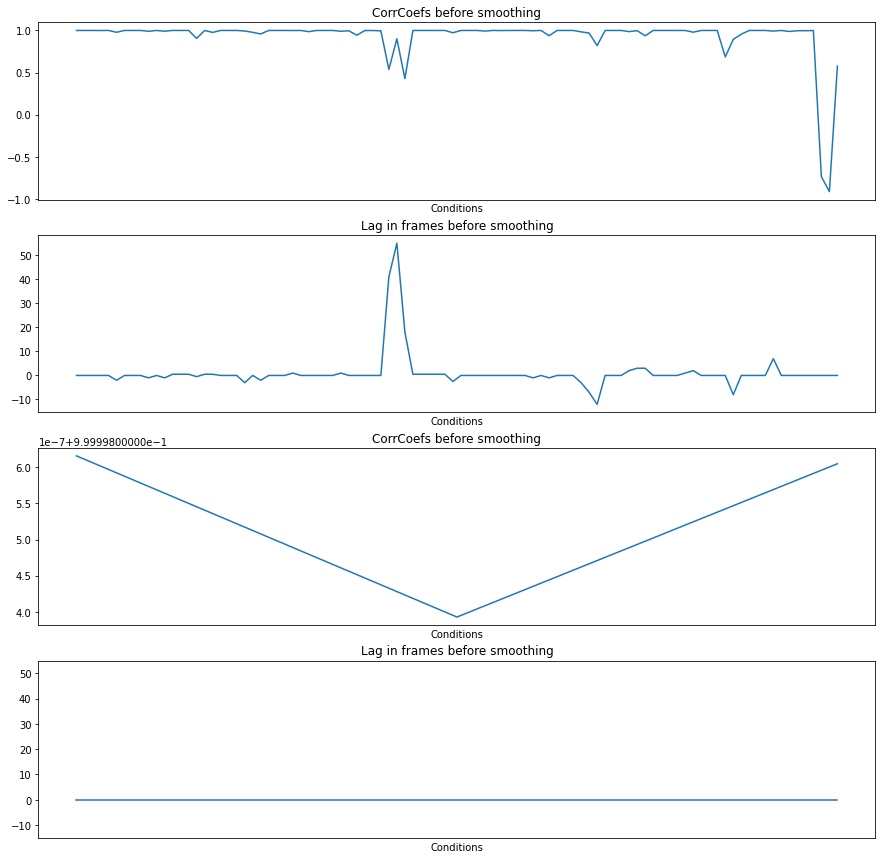

In [21]:
data_comp_df = pd.DataFrame.from_dict(data_comp_dict, orient="index")
#data_comp_df = data_comp_df.T

lag_df = pd.DataFrame.from_dict(lag_dict, orient='index')

smooth_comp_df = pd.DataFrame.from_dict(smooth_comp_dict, orient='index')

smooth_lag_df = pd.DataFrame.from_dict(smooth_lag_dict, orient='index')


col_names = ['CorrCoef']
data_comp_df.columns = col_names
smooth_comp_df.columns = col_names


plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
plt.plot(data_comp_df)
plt.xticks([])
plt.title('CorrCoefs before smoothing')
plt.xlabel('Conditions')

plt.subplot(4,1,2)
plt.plot(lag_df)
plt.xticks([])
plt.title('Lag in frames before smoothing')
plt.xlabel('Conditions')

plt.subplot(4,1,3)
plt.plot(smooth_comp_df)
plt.xticks([])
plt.title('CorrCoefs before smoothing')
plt.xlabel('Conditions')

plt.subplot(4,1,4)
plt.plot(smooth_lag_df)
plt.xticks([])
plt.ylim([-15,55])
plt.title('Lag in frames before smoothing')
plt.xlabel('Conditions')



### Plotting difference between some and all failed

In [ ]:
fig, axs = plt.subplots(nrows=96, ncols=3, figsize=(20,160))

car_data_names = ["CarPosition.x","CarPosition.y","CarPosition.z","CarRotation.x","CarRotation.y","CarRotation.z"]
areas = ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]
segments = [0,1,2,3]
ncols = 3

for idx, ax in enumerate(axs.reshape(-1)):
    
        
        car_data_idx = (idx // ncols) % len(car_data_names)
        segments_idx = (idx // (ncols * len(car_data_names)) ) % len(segments)
        area_idx = (idx // (ncols * len(car_data_names) * len(segments))) % len(areas)
        
        if (idx % 3 == 0):
            ax.plot(reference_paths_some_events_failed[areas[area_idx]][segments_idx]["resampled_timestamp"], \
                    reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
            ax.set_title("Some failed; " + car_data_names[car_data_idx] + "; Segment: " + str(segments[segments_idx]) + "; Area: " + areas[area_idx])
        elif (idx % 3 == 1):
            ax.plot(reference_paths_all_events_failed[areas[area_idx]][segments_idx]["resampled_timestamp"], \
                    reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
            ax.set_title("All failed; " + car_data_names[car_data_idx] + "; Segment: " + str(segments[segments_idx]) + "; Area: " + areas[area_idx])
        else:
            y = 0 # determine longer column 
            if (len(reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]) \
                > len(reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])):
                x = reference_paths_some_events_failed[areas[area_idx]][segments_idx]["resampled_timestamp"]
            else:
                x = reference_paths_all_events_failed[areas[area_idx]][segments_idx]["resampled_timestamp"]
            ax.plot(x, reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] \
                    - reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
            ax.set_title("Difference " + car_data_names[car_data_idx] + "; Segment: " + str(segments[segments_idx]) + "; Area: " + areas[area_idx])
                
        
fig.tight_layout()
plt.show()




### Plotting the above comparison for the cut data

In [ ]:
fig, axs = plt.subplots(nrows=96, ncols=3, figsize=(20,160))

car_data_names = ["CarPosition.x","CarPosition.y","CarPosition.z","car_rotation_direction.x","car_rotation_direction.y","car_rotation_direction.z"] #"CarRotation.x","CarRotation.y","CarRotation.z"]
areas = ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]
segments = [0,1,2,3]
ncols = 3

for idx, ax in enumerate(axs.reshape(-1)):
    
        
        car_data_idx = (idx // ncols) % len(car_data_names)
        segments_idx = (idx // (ncols * len(car_data_names)) ) % len(segments)
        area_idx = (idx // (ncols * len(car_data_names) * len(segments))) % len(areas)
        
        if (idx % 3 == 0):
            reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]
            ax.plot(reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
            ax.set_title("Some failed; " + car_data_names[car_data_idx] + "; Segment: " + str(segments[segments_idx]) + "; Area: " + areas[area_idx])
        elif (idx % 3 == 1):
            ax.plot(reference_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
            ax.set_title("All failed; " + car_data_names[car_data_idx] + "; Segment: " + str(segments[segments_idx]) + "; Area: " + areas[area_idx])
        else:
            ax.plot(reference_dict_some[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] \
                    - reference_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
            ax.set_title("Difference " + car_data_names[car_data_idx] + "; Segment: " + str(segments[segments_idx]) + "; Area: " + areas[area_idx])
                
        
fig.tight_layout()
plt.show()



